# <center>GIVE ME SOME CREDIT (BIGML)</center>
<div style="text-align: right">Tous droits réservés © Nicolas SEVERINO</div>

**BUT :** Améliorez l'état de la notation en matière de notation du crédit en prévoyant la probabilité que quelqu'un connaisse des difficultés financières au cours des deux prochaines années.

## 1ERE PARTIE - OPERATIONS SUR LE TRAINFULL SET

### Importation des modules obligatoires : 

BigML : API pour établir tout le processus décisionnel ;  
Pandas : API pour transmettre le résultat de notre algorithme et participer à la compétition ;  
Kaggle : Bibliotèque Python permettant la manipulation et l'analyse des données ;  
MatPlotLib : Visualisation graphique des données.

In [6]:
import bigml.api
from bigml.api import BigML
from pandas import read_csv, DataFrame
import kaggle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
#Commande permettant l'affichage avec la bibliothèque graphique intégrée à Jupyter Notebook
%matplotlib inline

### Lecture des fichiers CSV nécessaires

On envoie toutes les données d'un csv qui est dans le même dossier que ce script.

index_col=0 signifie qu'on traite la première colonne comme l'index (si on ne spécifie rien, ou si l'on met
index_col=None, ce qui est pareil, on va se retrouver avec une colonne supplémentaire et inutile: "Unnamed: 0").

In [8]:
df = read_csv('kaggle-give-me-credit-train.csv',index_col=0)
df_test_kaggle = read_csv('kaggle-give-me-credit-test.csv',index_col=0)

### Traitement du fichier "kaggle-give-me-credit-train.csv" (trainfull)

On ajoute de nouvelles features (des données) au sein de nouvelles colonnes pour améliorer la précision de notre algorithme d'apprentissage.

In [9]:
df['IncomePerPerson'] = df['MonthlyIncome'] / ( df['NumberOfDependents'] + 1 )
df.loc[df.age > 80, 'isOld'] = '1' 
df.loc[df.age <= 80, 'isOld'] = '0'
df['MonthlyDebt'] = df['MonthlyIncome'] * df['DebtRatio']
df['MonthlyBalance'] = df['MonthlyIncome'] - df['MonthlyDebt']
df['DebtPerPerson'] = df['MonthlyDebt'] / ( df['NumberOfDependents'] + 1 )
df['BalancePerPerson'] = df['MonthlyBalance'] / ( df['NumberOfDependents'] + 1 )
df['NumberOfTime30-89DaysPastDueNotWorse'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + df['NumberOfTime60-89DaysPastDueNotWorse']
df['NumbersOfOpen-NumberRealEstate'] = df['NumberOfOpenCreditLinesAndLoans'] - df['NumberRealEstateLoansOrLines']

On remplace les cellules vides par des 0

In [10]:
df = df.fillna(0)

On transfère toutes les données dans un fichier csv situé dans le même dossier que ce script.

index_label="Id" va mettre comme entête de la première colonne "Id" (nécessaire pour Kaggle).

In [11]:
df.to_csv('PANDAset.csv',index_label="Id")

Connexion à BigML dans le bon projet (identifiant et mot de passe dans un autre fichier pour plus de sécurité).  
Possibilité de supprimer également cette identification du projet pour plus de discrétion (Non nécessaire).


In [12]:
api = BigML(project="project/5d94a42242129f2e16000246")

### Création d'une source de données à partir du fichier

Création d'une source à partir du fichier csv modifié avec l'ajout de nouvelles features.

Obligatoire pour créer un modèle prédictif:  
- chaque colonne est une feature ;    
- chaque ligne est un input ;  
- la dernière colonne est normalement ce que l'on cherche à prévoir.

In [13]:
source = api.create_source('PANDAset.csv')

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [14]:
api.ok(source)
print("Source créée")

Source créée


### Transformation de la source en un ensemble de données traité et préparé pour le modèle

Création d'un dataset à partir de la source précédemment créée.

Un dataset est une version structurée d'une source dans laquelle chaque champs est traité et typé. Plusieurs types possibles : numérique, catégorique, texte,...

In [15]:
origin_dataset = api.create_dataset(source)

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [16]:
api.ok(origin_dataset)
print("Dataset créé")

Dataset créé


### Division de cet ensemble de données en 2 pour entrainement du modèle

On divise le dataset Trainfull en 2 : 
- Un sous-ensemble train (qui comprend 80% des données) ;  
- Un sous-ensemble validation (qui comprend 20% des données).

Information : "out_of_bag" signifie que l'ensemble de validation récupèrera le restant des données (donc les 20% du tout) / "seed" signifie que l'on souhaite que les 2 ensembles soient complémentaires.

In [17]:
train_dataset = api.create_dataset(
    origin_dataset, {"name": "PandaSet | TrainFull | Train (80%)",
                     "sample_rate": 0.8, "seed": "my seed"})
validation_dataset = api.create_dataset(
    origin_dataset, {"name": "PandaSet | TrainFull | Validation (20%)",
                     "sample_rate": 0.8, "seed": "my seed",
                     "out_of_bag": True})

In [20]:
train_csv = api.download_dataset(train_dataset,filename='train_prepared_V1.csv')
test_csv = api.download_dataset(validation_dataset,filename='val_prepared_V1.csv')

### Création d'un modèle prédictif de type "Model" 

Le modèle se base sur le sous-ensemble Train du dataset et on précise quelle est la donnée que l'on recherche.

In [12]:
deepnet = api.create_deepnet(train_dataset, {"objective_field" : "SeriousDlqin2yrs"})

### Mise en place d'une prédiction et traitement du fichier généré

La prédiction se fait à partir du modèle et s'applique sur le sous-ensemble de validation.  
On lui indique également qu'on retient tous les champs fournis (colonnes), leur entête, une colonne sur l'indice de confiance et les probabilités (2 colonnes vont être éditées).

In [13]:
batch_prediction = api.create_batch_prediction(deepnet, validation_dataset,{
    "all_fields": True, "header": True, "confidence" : True, "probabilities": True})

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [14]:
api.ok(batch_prediction)
print('Prediction faite')

Prediction faite


On télécharge notre prédiction dans un fichier csv dans le même dossier que ce script.

In [15]:
api.download_batch_prediction(batch_prediction,filename='my_predictions.csv')

'my_predictions.csv'

On parcoure le fichier généré en précisant que la première colonne est l'index du fichier.

In [16]:
split_pred = read_csv('my_predictions.csv',index_col=0)

On renomme l'entête de la colonne.

In [17]:
split_pred = split_pred.rename(columns={"SeriousDlqin2yrs.1":"MyPrediction"})

On génère un nouveau fichier csv traité avec pour entête de la première colonne: "Id".

In [18]:
split_pred.to_csv("my_prediction_v2.csv", index_label="Id")

# 2EME PARTIE - VERIFICATION DE L'EFFICACITE DU MODELE

### Evaluation de notre modèle

Evaluation faite à partir du modèle et sur le sous-ensemble de validation.

In [19]:
evaluation = api.create_evaluation(deepnet, validation_dataset)

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [20]:
api.ok(evaluation)
print('Evaluation faite')

Evaluation faite


### Matrice de confusion

On lit le dernier fichier traité, on définit l'index et on cache les entête du fichier pour ne garder qu'une liste.

In [21]:
data = read_csv('my_prediction_v2.csv', index_col=0, header=0)

On insère une nouvelle colonne en 12e position (pas important), dont le titre est "confusion_tag" et dont la valeur par défaut est 'none' (car on lui attribuera des valeurs plus tard).

In [22]:
data.insert(12,"confusion_tag",'none')

Fonction qui comparera 2 colonnes et attribuera dans la nouvelle colonne une valeur:  
FN (False Negative) / TP (True Positive) / FP (False Positive) / TN (True Negative)

In [23]:
def confusion(row):
    if row['SeriousDlqin2yrs'] == 0 and row['MyPrediction'] == 0:
        row['confusion_tag'] = 'TN'
    if row['SeriousDlqin2yrs'] == 1 and row['MyPrediction'] == 1:
        row['confusion_tag'] = 'TP'
    if row['SeriousDlqin2yrs'] == 1 and row['MyPrediction'] == 0:
        row['confusion_tag'] = 'FN'
    if row['SeriousDlqin2yrs'] == 0 and row['MyPrediction'] == 1:
        row['confusion_tag'] = 'FP'
    return row

On applique la fonction précédente pour chaque ligne.

In [24]:
data = data.apply(confusion, axis = 1)

On exporte les résultats dans un nouveau fichier csv.

In [25]:
data.to_csv('kaggle-give-me-credit-train_confusion.csv', index_label="Id")

On cherche à compter le nombre de TN, TP, FP, FN.

Pour chaque type, on cherche dans la colonne "confusion_tag" par une fonction qui nous retourne un tableau de booléens. Par exemple, dans le cas du TN (1ère ligne ci-dessous): la fonction data.loc va se placer dans la colonne concernée et vérifier si l'expression est vraie. Donc si sur la ligne il est indiqué "TN", la fonction va retourner "True". Tous les "True" sont conservés (pas les "False"). Puis on compte le nombre de valeurs contenues dans le tableau et on les affiche.

In [26]:
TN = len(data.loc[data['confusion_tag']=='TN'])
TP = len(data.loc[data['confusion_tag']=='TP'])
FP = len(data.loc[data['confusion_tag']=='FP'])
FN = len(data.loc[data['confusion_tag']=='FN'])
print(f'TN : {TN}')
print(f'TP : {TP}')
print(f'FP : {FP}')
print(f'FN : {FN}')

TN : 27494
TP : 486
FP : 491
FN : 1529


### Accuracy

Accuracy à partir de la matrice de confusion.

In [27]:
accuracy = (TN+TP)/(TN+TP+FN+FP)
accuracy

0.9326666666666666

### Précision

Précision à partir de la matrice de confusion = probabilité que ce soit vraiment vrai sachant qu'on prédit que c'est vrai.

In [28]:
precision = TP/(TP+FP)
precision

0.49744114636642783

### Recall

Recall à partir de la matrice de confusion = probabilité qu'on prédise que c'est vrai sachant que c'est vraiment vrai.

In [29]:
recall = TP/(TP+FN)
recall

0.2411910669975186

### Tri des 100 plus grosses erreurs

Création d'une nouvelle colonne (erreurs absolues) qui fait la différence entre la probabilité de la classe positive et l'output, dont on converti le résultat en valeur absolue.

In [30]:
data['absolute_error'] = (data['1 probability']-data['SeriousDlqin2yrs']).abs()

On classe la colonne par valeur par ordre décroissant et on sélectionne les 100 premières lignes.

In [31]:
desc_order = data.sort_values(by='absolute_error', ascending=False).head(100)

On exporte les résultats dans un nouveau fichier csv.

In [32]:
desc_order.to_csv('100_biggest_errors.csv',index_label="Id")

### Seuil et matrice de coûts / gains

In [33]:
def cost_threshold(threshold):
    prediction_threshold = data['1 probability'] > threshold

    #~ = "not" pour les tableaux / & = "and" pour les tableaux / | = "or" pour les tableaux
    
    P_pred = prediction_threshold
    N_pred = ~prediction_threshold
    
    P_real = (data['SeriousDlqin2yrs'] == 1)
    N_real = (data['SeriousDlqin2yrs'] == 0)
    
    TP = len(data.loc[P_pred & P_real])
    TN = len(data.loc[N_pred & N_real])
    FP = len(data.loc[P_pred & N_real])
    FN = len(data.loc[N_pred & P_real])
    
    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost
    
    return cost

### Visualisation graphique de la matrice de coûts

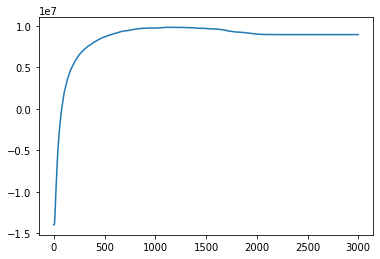

In [34]:
table = [cost_threshold(n/3000) for n in range(0,3000)]
plt.plot(table)

Ici, on cherche quelle est la valeur maximum atteinte et avec quel seuil

In [35]:
max_val = max(table)
max_threshold = table.index(max_val)/3000
print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est 9841500 et il est obtenu avec un seuil de 0.407


### AUC

AUC signifie "aire sous la courbe ROC". Cette valeur mesure l'intégralité de l'aire à deux dimensions située sous l'ensemble de la courbe ROC.

Cela correspond au nombre de valeurs de P trouvées dans la colonne '1 probability' par rapport au nombre de valeurs de N trouvées dans la même colonne.

In [36]:
#positive = (data['SeriousDlqin2yrs'] == 1)
#nb_positive = len(data.loc[positive])
#nb_negative = len(data.loc[~positive])
#results = data[['1 probability','SeriousDlqin2yrs']]
#threshold_list = results.sort_values(by='1 probability', ascending=False)['SeriousDlqin2yrs'].values

#auc = 0
#p_add = 0

#for i in range(len(threshold_list)):
#    if threshold_list[1] == 1:
#        p_add += 1
#    else:
#        auc += p_add

#auc = auc/(nb_positive*nb_negative)
is_positive = (data['SeriousDlqin2yrs'] == 1)
nb_positive = len(data.loc[is_positive])
nb_negative = len(data.loc[~is_positive])
df_threshold=DataFrame(index=data['1 probability'])
df_threshold['positive'] = is_positive.values
df_threshold.sort_index(inplace=True, ascending=False)

df_threshold['positive_sum'] =  df_threshold['positive'].cumsum()
auc=df_threshold.loc[~df_threshold['positive']]['positive_sum'].sum()/(nb_positive*nb_negative)
auc

0.8361523875560773

### Visualisation graphique de l'AUC

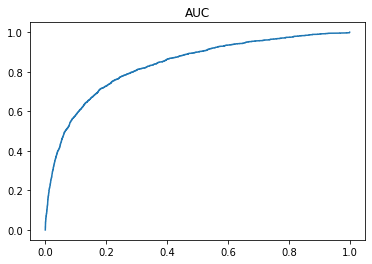

In [37]:
threshold_list = data.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values

tpr = []
fpr = []

positive_sum = 0
negative_sum = 0
for i in range(len(threshold_list)):
    if threshold_list[i] == 1:
        positive_sum += 1
    else:
        negative_sum += 1
    tpr.append(positive_sum/nb_positive)
    fpr.append(negative_sum/nb_negative)
plt.title('AUC')
plt.plot(fpr,tpr)
plt.show()

### Visualisations graphiques des learning curves

Le train set de départ va être divisé en 10 sous-sets comprenant 10% des données de l'ensemble.

Les learning curves servent à visualiser un graphe avec les courbes d'un modèle Deepnet et d'un modèle Ensemble effectués tous les 2 sur un chaque sous-set.

In [42]:
AUC = []
AUC_deep = []
sizes = []

for i in range(1,11):
    train_dataset_split = api.create_dataset(train_dataset, {"name": f"Train Split {i/10}",
                     "sample_rate": i/10, "seed": "my seed"})
    api.ok(train_dataset_split)
    model = api.create_ensemble(train_dataset_split,{"objective_field" : "SeriousDlqin2yrs"})
    evaluation = api.create_evaluation(model, validation_dataset)
    api.ok(evaluation)
    myauc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    
    model_deep = api.create_deepnet(train_dataset_split,{"objective_field" : "SeriousDlqin2yrs"})
    evaluation_deep = api.create_evaluation(model_deep, validation_dataset)
    api.ok(evaluation_deep)
    myauc_deep = evaluation_deep['object']['result']['model']['average_area_under_roc_curve']
    
    AUC.append(myauc)
    AUC_deep.append(myauc_deep)
    sizes.append(i/10)

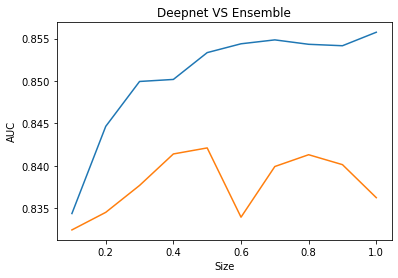

In [45]:
size=[a/10 for a in range(1,11)]
graph1 = plt.plot(size,AUC)
graph2 = plt.plot(size,AUC_deep)

plt.title('Deepnet VS Ensemble')
plt.xlabel('Size')
plt.ylabel('AUC')
plt.show()

In [47]:
AUC_deep

[0.83246,
 0.83453,
 0.8377,
 0.84141,
 0.84212,
 0.83396,
 0.83993,
 0.84132,
 0.84015,
 0.83626]

# 3EME PARTIE - OPERATIONS SUR LE TEST SET

### Traitement du fichier "kaggle-give-me-credit-test.csv" (test)

On ajoute de nouvelles features (des données) au sein de nouvelles colonnes pour améliorer la précision.

In [37]:
df_test_kaggle['IncomePerPerson'] = df_test_kaggle['MonthlyIncome'] / ( df_test_kaggle['NumberOfDependents'] + 1 )
df_test_kaggle.loc[df_test_kaggle.age > 80, 'isOld'] = '1' 
df_test_kaggle.loc[df_test_kaggle.age <= 80, 'isOld'] = '0'
df_test_kaggle['MonthlyDebt'] = df_test_kaggle['MonthlyIncome'] * df_test_kaggle['DebtRatio']
df_test_kaggle['MonthlyBalance'] = df_test_kaggle['MonthlyIncome'] - df_test_kaggle['MonthlyDebt']
df_test_kaggle['DebtPerPerson'] = df_test_kaggle['MonthlyDebt'] / ( df_test_kaggle['NumberOfDependents'] + 1 )
df_test_kaggle['BalancePerPerson'] = df_test_kaggle['MonthlyBalance'] / ( df_test_kaggle['NumberOfDependents'] + 1 )
df_test_kaggle['NumberOfTime30-89DaysPastDueNotWorse'] = df_test_kaggle['NumberOfTime30-59DaysPastDueNotWorse'] + df_test_kaggle['NumberOfTime60-89DaysPastDueNotWorse']
df_test_kaggle['NumbersOfOpen-NumberRealEstate'] = df_test_kaggle['NumberOfOpenCreditLinesAndLoans'] - df_test_kaggle['NumberRealEstateLoansOrLines']

On remplace les valeurs vides par des 0.

In [38]:
df_test_kaggle = df_test_kaggle.fillna(0)

On transfère toutes les données dans un fichier csv situé dans le même dossier que ce script.

index_label="Id" va mettre comme entête de la première colonne "Id" (nécessaire pour Kaggle).

In [39]:
df_test_kaggle.to_csv('PANDAset_test.csv', index_label="Id")

### Création d'une source de données à partir du fichier

Création d'une source à partir du fichier csv modifié avec l'ajout de nouvelles feature.

Même logique que pour Trainfull.

In [40]:
source_test = api.create_source('PANDAset_test.csv')

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [41]:
api.ok(source_test)
print("Source créée")

Source créée


### Transformation de la source en un ensemble de données traité et préparé pour le modèle

Création d'un dataset à partir de la source précédemment créée.

Même logique que pour Trainfull.

In [42]:
origin_dataset_test = api.create_dataset(source_test)

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [43]:
api.ok(origin_dataset_test)
print("Dataset créé")

Dataset créé


### Création d'un modèle prédictif de type "Model"

Création d'un modele ensemble sur la partie Train du dataset et on precise quelle est la donnée que l'on recherche.

In [44]:
deepnet2 = api.create_deepnet(origin_dataset, {"objective_field":"SeriousDlqin2yrs"})

### Mise en place d'une prédiction

Création de la prediction à partir du modèle et sur l'ensemble de test.

Même logique que pour le Trainfull.

In [45]:
batch_prediction2 = api.create_batch_prediction(deepnet2, origin_dataset_test, {
    "output_fields":["Id"], "header": True, "confidence" : True, "probabilities": True})

Commandes qui nous permettent de s'assurer que l'étape précédente a bien été réalisée.

In [46]:
api.ok(batch_prediction2)
print("Prédiction faite")

Prédiction faite


On télécharge notre prédiction dans un fichier csv dans le même dossier que ce script.

In [47]:
api.download_batch_prediction(batch_prediction2,filename='my_final_predictions.csv')

'my_final_predictions.csv'

# 4EME PARTIE - FORMATTAGE DU FICHIER ET ENVOI A KAGGLE

### Formattage du fichier de prédictions finales

On veut repartir du fichier précédemment fait.

In [48]:
submit = read_csv('my_final_predictions.csv',index_col=0)

On modifie l'intitulé de 2 colonnes pour correspondre à ce qu'attend Kaggle.

In [49]:
submit = submit.rename(columns={'1 probability': 'Probability'})

On supprime toutes les colonnes inutiles pour l'envoi à Kaggle.

In [50]:
submit = submit.drop(columns={'confidence', '0 probability', 'SeriousDlqin2yrs'})

On met ce nouveau fichier formaté dans un autre fichier dédié à l'envoi sur Kaggle.

In [51]:
submit.to_csv("submitKaggle.csv", index_label="Id")

### Envoi à Kaggle

Transmission du fichier directement sur Kaggle.

In [52]:
kaggle.api.competition_submit("submitKaggle.csv", "Essai","GiveMeSomeCredit")

100%|██████████| 1.65M/1.65M [00:04<00:00, 379kB/s] 


Successfully submitted to Give Me Some Credit

In [53]:
print("Fichier bien transmis sur Kaggle. Bonne chance !")

Fichier bien transmis sur Kaggle. Bonne chance !
